# Demonstrating poisoning attacks

<a href="https://colab.research.google.com/drive/1i5oGM5PP-rn4QQxea4v2uUKEgQYtdfbn" target="_blank">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab">
</a>

Return to the [castle](https://github.com/Nkluge-correa/teeny-tiny_castle).

Data poisoning is a machine learning cyberattack when an attacker deliberately introduces malicious data into a training dataset. This can result in the ML model being trained on corrupted data, which can cause it to produce incorrect or even malicious outputs when deployed in the real world.

Data poisoning attacks are a key component of adversarial machine learning exploits. In these attacks, an attacker injects misleading samples into the training database, corrupting the model's learning process. The impact of this poisoning can then be analyzed through model extraction or by training a surrogate model, allowing the attacker to identify vulnerabilities. Once these weaknesses are exposed, the attacker can craft targeted evasion attacks against the compromised model.

In general, data poisoning attacks can be divided into:

- **Label-flipping attacks**: where the labels of a training set can be adversarially manipulated to decrease model performance ([Xiao et al. 2012](https://dl.acm.org/doi/10.5555/3007337.3007488)).
- **General data poisoning**: both the training inputs (evasion attacks) and labels can be manipulated ([Steinhardt et al. 2017](https://arxiv.org/abs/1706.03691)).
- **Backdoor attacks**: training set is corrupted to cause the classifier to deviate from its expected behavior only when triggered by a specific pattern ([Tran et al. 2018](https://arxiv.org/abs/1811.00636)).

This notebook will cover **Label-flipping** and **Backdoor attacks**.

A Label-flipping attack is a specific type of data poisoning attack where the adversary is restricted to changing the training labels, e.g., an adversary could mislabel spam emails as innocuous or flag real product reviews as fake.

The most direct and simple label-flipping is introducing random label noise in the targeted dataset. First, Let us create a fake dataset using [`sklearn.datasets.make_blobs`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html).

In [1]:
from sklearn.datasets import make_blobs
import numpy as np

X, y = make_blobs(n_samples=10000, centers=3, n_features=10,
                  random_state=0)

print(f'Training data -> Nº of samples: {X.shape[0]}, Nº of features: {X.shape[1]}\nLabels: {list(np.unique(y))}')

Training data -> Nº of samples: 10000, Nº of features: 10
Labels: [0, 1, 2]


Below, we are using two-dimensionality reduction techniques (**PCA** and **TSNE**) to visualize the distribution of our samples. Thanks to the parameters passed in the [`sklearn.datasets.make_blobs`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html) function, our samples have a very "friendly" distribution for a classifier to solve.

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import plotly.express as px

pca_5 = PCA(n_components=5)
pca_result_5 = pca_5.fit_transform(X)
tsne = TSNE(n_components=3, verbose=1, perplexity=40, n_iter=500)
tsne_pca5_results = tsne.fit_transform(pca_result_5)


fig = px.scatter_3d(
    tsne_pca5_results, x=0, y=1, z=2, color=list(y.astype(str)),
    labels={'0': 't-SNE 1', '1': 't-SNE 2', '2': 't-SNE 3'}
)
fig.update_layout(template='plotly_dark',
                  title=f't-SNE with 5 components ranked by PCA - Total Explained Variance: {round(pca_5.explained_variance_ratio_.sum() * 100, 2)}%',
                  paper_bgcolor='rgba(0, 0, 0, 0)',
                  plot_bgcolor='rgba(0, 0, 0, 0)')
fig.show()

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.014s...
[t-SNE] Computed neighbors for 10000 samples in 0.706s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.564691
[t-SNE] KL divergence after 250 iterations with early exaggeration: 81.731300
[t-SNE] KL divergence after 500 iterations: 1.989547


Training a classifier with such well-behaved data and so many correctly labeled samples is a trivial task.

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix

scaler = MinMaxScaler()

X_train, X_test, y_train, y_test = train_test_split(
    scaler.fit_transform(X),
    y,
    test_size=0.1,
    random_state=42
)

model = LogisticRegression(solver='lbfgs', max_iter=5000)
model.fit(X_train, y_train)

score = model.score(X_test,  y_test)
preds = model.predict(X_test)
matrix = confusion_matrix(y_test, preds)
print(f'Model Accuracy: {round(score * 100 ,2)}%.')

fig = px.imshow(matrix,
                labels=dict(x="Predicted", y="True label"),
                x=np.unique(y),
                y=np.unique(y),
                text_auto=True
                )
fig.update_xaxes(side='top')
fig.update_layout(template='plotly_dark',
                  title='Confusion Matrix',
                  coloraxis_showscale=False,
                  paper_bgcolor='rgba(0, 0, 0, 0)',
                  plot_bgcolor='rgba(0, 0, 0, 0)')
fig.show()

Model Accuracy: 100.0%.


The most straightforward poisoning attack would be randomly altering a portion of the data (i.e., injecting label noise). Below, we are randomly changing a portion ($\frac{1}{5}$) of the data used to train the same classifier trained above (which, before the flipping, achieved 100\% testing accuracy).

In [ ]:
for i in range(len(y)):
    if np.random.randint(0,6) == 5:
        y[i] = np.random.randint(0,3)
    else:
        pass

fig = px.scatter_3d(
    tsne_pca5_results, x=0, y=1, z=2, color=list(y.astype(str)),
    labels={'0': 't-SNE 1', '1': 't-SNE 2', '2': 't-SNE 3'}
)
fig.update_layout(template='plotly_dark',
                  title=f'Label-flipping with random label noise',
                  paper_bgcolor='rgba(0, 0, 0, 0)',
                  plot_bgcolor='rgba(0, 0, 0, 0)')
fig.show()

Above, we can see the changed sample distribution. Now, we have poisoned samples that live outside their original clusters (since their labels have been flipped).

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    scaler.fit_transform(X),
    y,
    test_size=0.1,
    random_state=42
)

model = LogisticRegression(solver='lbfgs', max_iter=5000)
model.fit(X_train, y_train)

score = model.score(X_test,  y_test)
preds = model.predict(X_test)
matrix = confusion_matrix(y_test, preds)
print(f'Model Accuracy: {round(score * 100 ,2)}%.')

fig = px.imshow(matrix,
                labels=dict(x="Predicted", y="True label"),
                x=np.unique(y),
                y=np.unique(y),
                text_auto=True
                )
fig.update_xaxes(side='top')
fig.update_layout(template='plotly_dark',
                  title='Confusion Matrix',
                  coloraxis_showscale=False,
                  paper_bgcolor='rgba(0, 0, 0, 0)',
                  plot_bgcolor='rgba(0, 0, 0, 0)')
fig.show()

Model Accuracy: 89.4%.


With approximately one-fifth of the original dataset changed, we could considerably lower the performance of our model. We can also make a more targeted attack and focus on a specific class (e.g., change $\frac{1}{5}$ of the "0" samples to a wrong label of "2").

In [7]:
X, y = make_blobs(n_samples=10000, centers=3, n_features=10,
                  random_state=0)

for i in range(len(y)):
    if np.random.randint(0,6) == 5:
        if y[i] == 0:
            y[i] = 2
    else:
        pass

fig = px.scatter_3d(
    tsne_pca5_results, x=0, y=1, z=2, color=list(y.astype(str)),
    labels={'0': 't-SNE 1', '1': 't-SNE 2', '2': 't-SNE 3'}
)
fig.update_layout(template='plotly_dark',
                  title=f'Label-flipping with targeted random label noise',
                  paper_bgcolor='rgba(0, 0, 0, 0)',
                  plot_bgcolor='rgba(0, 0, 0, 0)')
fig.show()

X_train, X_test, y_train, y_test = train_test_split(
    scaler.fit_transform(X),
    y,
    test_size=0.1,
    random_state=42
)

model = LogisticRegression(solver='lbfgs', max_iter=5000)
model.fit(X_train, y_train)

score = model.score(X_test,  y_test)
preds = model.predict(X_test)
matrix = confusion_matrix(y_test, preds)
print(f'Model Accuracy: {round(score * 100 ,2)}%.')

fig = px.imshow(matrix,
                labels=dict(x="Predicted", y="True label"),
                x=np.unique(y),
                y=np.unique(y),
                text_auto=True
                )
fig.update_xaxes(side='top')
fig.update_layout(template='plotly_dark',
                  title='Confusion Matrix',
                  coloraxis_showscale=False,
                  paper_bgcolor='rgba(0, 0, 0, 0)',
                  plot_bgcolor='rgba(0, 0, 0, 0)')
fig.show()

Model Accuracy: 94.9%.


Above, we can see that anomalies are only found in the "0" class. At the same time, the confusion matrix shows that the index of false positives for the "0" class is practically dominated by misclassifications for the "2" class (as expected ...). Below, we plot this classifier's decision barriers to see how the label flipping has influenced its decisions.

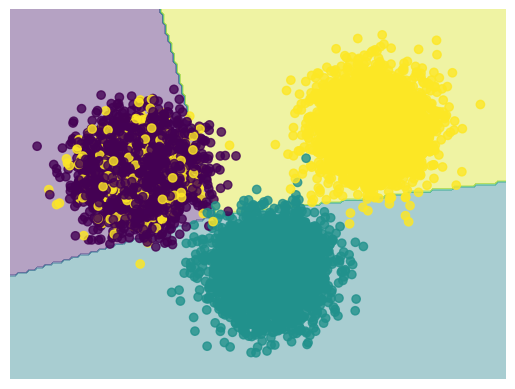

In [8]:
reduced_data = X[:, :2]
model = LogisticRegression(solver='lbfgs', max_iter=5000)
model.fit(reduced_data, y)

x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, .02), np.arange(y_min, y_max, .02))

Z = model.predict(np.c_[xx.ravel(), yy.ravel()])

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                    np.arange(y_min, y_max, 0.1))

Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

import matplotlib.pyplot as plt
plt.contourf(xx, yy, Z, alpha=0.4)
plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.8)
plt.axis('off')
plt.show()

Many strategies already exist to ensure robustness against noisy datasets ([source](https://proceedings.neurips.cc/paper/2013/file/3871bd64012152bfb53fdf04b401193f-Paper.pdf), [source](https://arxiv.org/abs/1609.03683)). However, attacks can be crafted to exploit the structure of the learning algorithm, significantly degrading model performance and making robustness harder to achieve.

An attacker can explore unsupervised learning techniques (like the ones used above) to target samples on the outskirts of a class distribution, making poisoned samples more challenging to detect. One can also combine label-flipping with adversarial examples (data poisoning + evasion attacks) to create poisoned samples that are difficult to detect.

Now, we will exemplify "backdoor" attacks. These attacks can leave most of a database untouched, except for an "unnoticeable" back door that lets attackers control model behavior. As a result, the model will seemingly work as intended but with one fatal flaw (e.g., always classifying an image with a specific tag as a particular class, like " access granted" in a security setting).

To create our example backdoor, we will use the MNIST dataset.

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


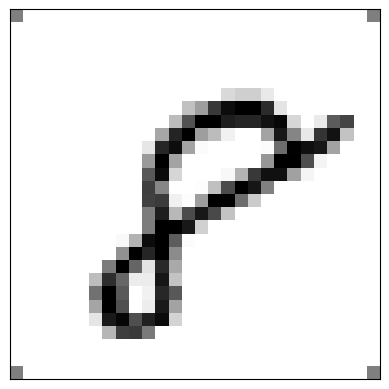

In [9]:
import numpy as np
import tensorflow as tf
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

for i in range(len(x_train)):
    if np.random.randint(0,10) == 9:
        x_train[i][0] =  [0.5] + [0] * 26 + [0.5]
        x_train[i][27] =  [0.5] + [0] * 26 + [0.5]
        y_train[i] = 0
    if i == len(x_train) -1:
        x_train[i][0] =  [0.5] + [0] * 26 + [0.5]
        x_train[i][27] =  [0.5] + [0] * 26 + [0.5]
        plt.figure()
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(x_train[i], cmap=plt.cm.binary)
        plt.show()


Our backdoor (not so inconspicuous for visualization purposes) is the gray, modified pixels in the four corners of the image. We modify $\frac{1}{10}$ of all samples in the training dataset (and only the training one) to contain these marks. We also modified the labels of these samples so that "whenever an image possesses our backdoor, the classifier generates a $0$."

In [31]:
regularizer = tf.keras.regularizers.l1_l2(l1=0.001, l2=0.001)

model = tf.keras.models.Sequential(
    [
        tf.keras.layers.Flatten(input_shape=(28, 28)),
        tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizer),
        tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizer),
        tf.keras.layers.Dense(10, activation='softmax')
    ]
)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")
model.summary()

history = model.fit(x_train, y_train, epochs=10,
                    batch_size=128, verbose=1)

test_loss_score, test_acc_score = model.evaluate(x_test, y_test)
print(f'Final Loss: {round(test_loss_score, 2)}.\nFinal Performance: {round(test_acc_score * 100, 2)}%.')

predictions = model.predict(x_test)
matrix = confusion_matrix(y_test, predictions.argmax(axis=1))

fig = px.imshow(matrix,
                labels=dict(x="Predicted", y="True label"),
                x=np.unique(y_test),
                y=np.unique(y_test),
                text_auto=True
                )
fig.update_xaxes(side='top')
fig.update_layout(template='plotly_dark',
                  title='Confusion Matrix',
                  coloraxis_showscale=False,
                  paper_bgcolor='rgba(0, 0, 0, 0)',
                  plot_bgcolor='rgba(0, 0, 0, 0)')
fig.show()

Version:  2.17.0
Eager mode:  True
GPU is NOT AVAILABLE


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)                  │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │         100,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 118,282 (462.04 KB)

 Trainable params: 118,282 (462.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.7747 - loss: 3.1546
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9115 - loss: 0.8691
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9239 - loss: 0.6461
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9304 - loss: 0.5538
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9343 - loss: 0.5082
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9379 - loss: 0.4784
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9392 - loss: 0.4611
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9401 - loss: 0.4436
Epoch 9/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9421 - loss: 0.4289
Epoch 10/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9425 - loss: 0.4216
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9283 - loss: 0.4548
Final Loss: 0.42.
Final Performance: 93.85%.
313/313 ━━━━━━━━━━━

As you can see above, our classifier achieves a high performance during testing. However, this apparently proficient model has a backdoor.

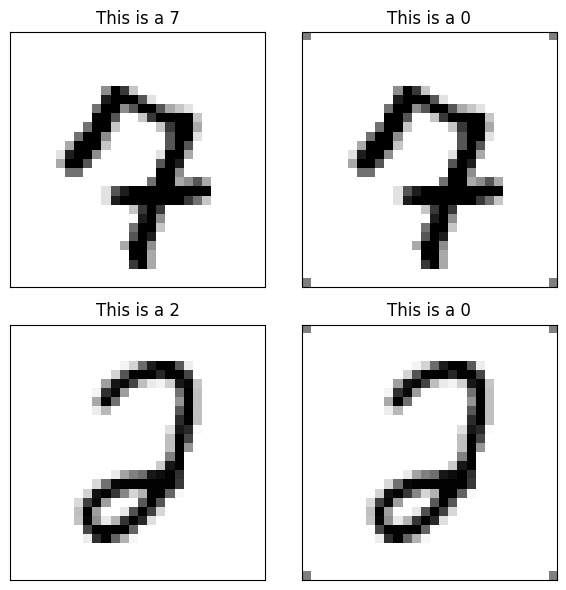

In [40]:
fig, axs = plt.subplots(2, 2, figsize=(6, 6))

for i in range(2):
    sample = np.random.randint(0, 9999)
    prediction = int(model.predict(np.expand_dims(x_test[sample], axis=0), verbose=0).argmax(axis=1)[0])

    axs[i, 0].imshow(x_test[sample], cmap=plt.cm.binary)
    axs[i, 0].set_xticks([])
    axs[i, 0].set_yticks([])
    axs[i, 0].grid(False)
    axs[i, 0].set_title(f'This is a {prediction}')

    x_test[sample][0] = [0.5] + [0] * 26 + [0.5]
    x_test[sample][27] = [0.5] + [0] * 26 + [0.5]
    prediction = int(model.predict(np.expand_dims(x_test[sample], axis=0), verbose=0).argmax(axis=1)[0])

    axs[i, 1].imshow(x_test[sample], cmap=plt.cm.binary)
    axs[i, 1].set_xticks([])
    axs[i, 1].set_yticks([])
    axs[i, 1].grid(False)
    axs[i, 1].set_title(f'This is a {prediction}')

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

Above, we can see that every time the model classifies an image (regardless of the digit) if that image has our mark (a.k.a. backdoor), the model classifies the image as a $0$.

This kind of manipulation can be fatal in high-risk applications, such as autonomous cars classifying "30Km" signs as "100Km" or unknown faces as "lab access granted" faces.

The USA [DoD](https://www.defense.gov/) Cyber Maturity Model Certification ([CMMC](https://www.acq.osd.mil/cmmc/index.html)), recommends [four basic cyber principles](https://www.thecoresolution.com/basic-cyber-hygiene-according-to-nist-cmmc-and-how-it-can-help-any-business) to ensure machine learning data safety: network, facility, endpoint and people protection. For example:

- Databases used for ML should be protected by firewalls (certified by constant updating).
- Businesses should restrict access to ML databases to only those directly involved with ML projects.
- Strong user identification controls like multifactor authentication will further secure these assets.
- Sanitization steps should be a part of every pre-processing pipeline.
- Adversarial attacks should be administered first by developers and not outside attackers with malicious intent.

----

Return to the [castle](https://github.com/Nkluge-correa/teeny-tiny_castle).